```text
TECHNICAL PROCESSES

temporarily split into 3 blocks:
    downloading and processing data by running a batch script
    loading processed ready-to-use csv files
    setting up the dataframes necessary for further analysis and visualization


THIS IS ONLY A REFORMATTING SUGGESTION, WHICH AIMS TO MAKE THE NOTEBOOK MORE READABLE AND STREAMLINED FOR THE USER
IT IS NOT THE UPDATE OF THE PREVIOUS PROJECT NOTEBOOK FILE, BUT MERELY A PROPOSED ALTERNATIVE, THEREFORE IT HAS BEEN COMMITTED AS A SEPARATE FILE
THE DATA ANALYSIS / VISUALIZATION HAS NOT BEEN CHANGED, EXCEPT FOR UPDATING CERTAIN VARIABLE NAMES, BUT FUNCTIONALITY HAS REMAINED UNCHANGED
```

In [231]:
import subprocess
import pandas as pd
import os
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# downloads and updates data

exclude = {"transform_universal.py"}

scripts_dir = os.getcwd()

scripts = sorted(
    f for f in os.listdir(scripts_dir)
    if f.endswith(".py") and f not in exclude
)

for f in scripts:
    print(f"Running: {f}")
    subprocess.run([sys.executable, f], cwd=scripts_dir, check=True)

print("All scripts finished.")


Running: download_static.py
Running: transform_calendar_calendar_dates.py
Running: transform_routes.py
Running: transform_stop_times.py
Running: transform_stops.py
Running: transform_transfers.py
Running: transform_trips.py
All scripts finished.


In [2]:
# loading csv files
data = {}
for name in ["stops_processed.csv", "routes_processed.csv", "trips_processed.csv", "stop_times_processed.csv", "calendar_processed.csv", "calendar_dates_processed.csv", "transfers_processed.csv"]:
    df = pd.read_csv(os.path.join("data/processed",name),low_memory=False)
    name = name[:-4]
    data[name] = df

In [3]:
# setting up dataframes

stops_df          = data["stops_processed"]
routes_df         = data["routes_processed"]
trips_df          = data["trips_processed"]
stop_times_df     = data["stop_times_processed"]
calendar_df       = data["calendar_processed"]
calendar_dates_df = data["calendar_dates_processed"]
transfers_df      = data["transfers_processed"]

# merging dataframes

route_type_df     = routes_df[["route_type", "route_id"]]
route_type_df     = pd.merge(route_type_df, trips_df[['route_id', 'trip_id']], on='route_id')
route_type_df     = pd.merge(route_type_df, stop_times_df[['stop_id', 'trip_id']], on='trip_id')
route_type_df     = pd.merge(route_type_df, stops_df[['stop_id', 'stop_name']], on='stop_id')
trips_trans       = pd.merge(trips_df, routes_df[["route_type", "route_id"]], on = "route_id")
stop_times_trans  = pd.merge(stop_times_df, trips_trans[["route_type", "trip_id"]], on = "trip_id")
stop_trans        = pd.merge(stops_df, stop_times_trans[["route_type", "stop_id"]], on = "stop_id")



## HIGHEST VISIBILITY

In [192]:
def compute_high_visibility(stop_times_df, stops_df):
    """
    Compute high-visibility stops based on the number of unique trips per stop.
    
    Parameters:
        stop_times_df (pd.DataFrame): Must contain 'stop_id' and 'trip_id'.
        stops_df (pd.DataFrame): Must contain 'stop_id' and 'stop_name'.
    
    Returns:
        pd.DataFrame: stop_name and total number of trips, sorted descending by trips.
    """
    trips_count = stop_times_df.groupby('stop_id')['trip_id'].nunique().reset_index()
    
    high_visibility = stops_df[['stop_id', 'stop_name']]
    high_visibility = pd.merge(high_visibility, trips_count, on='stop_id', how='left')
    
    high_visibility = (high_visibility.groupby('stop_name', as_index=False)['trip_id'].sum().sort_values('trip_id', ascending=False).reset_index(drop=True))
    
    return high_visibility

In [193]:
high_visibility = compute_high_visibility(stop_times_df, stops_df)
high_visibility.head(10)

,stop_name,trip_id
0,Želivského,7593.0
1,Smíchovské nádraží,6971.0
2,Anděl,6926.0
3,Palmovka,6060.0
4,Kobylisy,5881.0
5,Lihovar,5876.0
6,Černý Most,5769.0
7,Karlovo náměstí,5471.0
8,Florenc,5159.0
9,Letňany,5119.0


In [209]:
high_visibility[high_visibility["stop_name"] == "Volha"]

,stop_name,trip_id
526,Volha,653.0


In [194]:
def test_compute_high_visibility():
    stop_times_test = pd.DataFrame({
        'stop_id': [1, 1, 2, 3, 3, 3],
        'trip_id': ['a','b','c','d','e','f']})   
    stops_test = pd.DataFrame({
        'stop_id': [1, 2, 3],
        'stop_name': ['StopA', 'StopB', 'StopC']})
    
    result = compute_high_visibility(stop_times_test, stops_test)
    
    expected = pd.DataFrame({'stop_name': ['StopC', 'StopA', 'StopB'], 'trip_id': [3, 2, 1]})
    
    pd.testing.assert_frame_equal(result.reset_index(drop=True), expected)
    
    print("test_compute_high_visibility PASSED")

# running the test
test_compute_high_visibility()

test_compute_high_visibility PASSED


## LONGEST EXPOSURE

### 1. longest amount of time

In [139]:
def time_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h*3600 + m*60 + s

In [195]:
def get_first_arrival_seconds(stop_times_df):
    """
    Returns a DataFrame with first arrival per trip in seconds.
    """
    first_rows = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmin()]
    first_rows = first_rows[['trip_id', 'arrival_time']].copy()
    first_rows['arrival_seconds'] = first_rows['arrival_time'].apply(time_to_seconds)
    return first_rows


def get_last_arrival_seconds(stop_times_df):
    """
    Returns a DataFrame with last arrival per trip in seconds.
    """
    last_rows = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmax()]
    last_rows = last_rows[['trip_id', 'arrival_time']].copy()
    last_rows['arrival_seconds'] = last_rows['arrival_time'].apply(time_to_seconds)
    return last_rows

In [196]:
def compute_trip_durations(first_arrivals, last_arrivals):
    """
    Computes duration (seconds) per trip.
    Returns a DataFrame: ['trip_id', 'duration_seconds']
    """
    duration_series = last_arrivals.set_index('trip_id')['arrival_seconds'] - \
                      first_arrivals.set_index('trip_id')['arrival_seconds']
    duration_df = duration_series.reset_index()
    duration_df = duration_df.rename(columns={'arrival_seconds': 'duration_seconds'})
    return duration_df

In [199]:
class RouteDurationAnalyzer:
    """
    Computes average duration per route with optional filtering.
    """

    def __init__(self, stop_times_df, trips_df, routes_df):
        self.stop_times_df = stop_times_df
        self.trips_df = trips_df
        self.routes_df = routes_df

    def compute_avg_duration_per_route(self, exclude_regional=True):
        # Get first and last arrivals in seconds
        first_arrivals = get_first_arrival_seconds(self.stop_times_df)
        last_arrivals = get_last_arrival_seconds(self.stop_times_df)

        # Compute durations per trip
        duration_df = compute_trip_durations(first_arrivals, last_arrivals)

        # Merge with trips_df to get route_id
        duration_df = pd.merge(duration_df, self.trips_df[['trip_id', 'route_id']], on='trip_id')

        # Compute average duration per route
        avg_duration_per_route = duration_df.groupby('route_id')['duration_seconds'].mean().reset_index()

        # Convert to minutes
        avg_duration_per_route['duration_minutes'] = round(avg_duration_per_route['duration_seconds'] / 60, 0)

        # Merge with routes_df to get route_short_name and is_regional
        avg_duration_per_route = pd.merge(
            avg_duration_per_route,
            self.routes_df[['route_short_name', 'route_id', 'is_regional']],
            on='route_id'
        )

        # Optionally exclude regional routes
        if exclude_regional:
            avg_duration_per_route = avg_duration_per_route[avg_duration_per_route['is_regional'] != 1]

        # Sort descending by duration
        avg_duration_per_route = avg_duration_per_route.sort_values(by='duration_seconds', ascending=False).reset_index(drop=True)

        avg_duration_per_route = avg_duration_per_route[
            [
                'route_id',
                'route_short_name',
                'is_regional',
                'duration_seconds',
                'duration_minutes'
            ]
        ]
        
        return avg_duration_per_route

In [200]:
analyzer = RouteDurationAnalyzer(stop_times_df, trips_df, routes_df)

# Compute average duration per route (minutes), excluding regional routes
avg_duration_routes = analyzer.compute_avg_duration_per_route()

avg_duration_routes.head(10)

,route_id,route_short_name,is_regional,duration_seconds,duration_minutes
0,L911,911,0,4648.888889,77.0
1,L910,910,0,4374.000000,73.0
2,L95,95,0,4303.333333,72.0
3,L136,136,0,4185.159574,70.0
4,L908,908,0,4166.250000,69.0
5,L913,913,0,4164.000000,69.0
6,L904,904,0,4092.000000,68.0
7,L166,166,0,3941.111111,66.0
8,L907,907,0,3881.052632,65.0
9,L97,97,0,3832.173913,64.0


In [203]:
def test_compute_avg_duration_per_route():
    stop_times_test = pd.DataFrame({
        'trip_id': ['t1', 't1', 't2', 't2'],
        'arrival_time': ['08:00:00', '08:30:00', '09:00:00', '09:20:00']})
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2'],
        'route_id': ['r1', 'r2']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2'],
        'route_short_name': ['A', 'B'],
        'is_regional': [0, 1] })

    analyzer = RouteDurationAnalyzer(stop_times_test, trips_test, routes_test)
    result = analyzer.compute_avg_duration_per_route(exclude_regional=True)

    expected = pd.DataFrame({
        'route_id': ['r1'],
        'route_short_name': ['A'],
        'is_regional': [0],
        'duration_seconds': [1800.0],
        'duration_minutes': [30.0]
    })

    assert list(result.columns) == [
        'route_id',
        'route_short_name',
        'is_regional',
        'duration_seconds',
        'duration_minutes'
    ]

    pd.testing.assert_frame_equal(result.reset_index(drop=True), expected)

    print("test_compute_avg_duration_per_route PASSED")

test_compute_avg_duration_per_route()

test_compute_avg_duration_per_route PASSED


#### old code

In [140]:
## defining first rows and compusing seconds ##
first_rows = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmin()]

first_rows = first_rows[["trip_id", "arrival_time"]]
first_rows['arrival_seconds'] = (
    first_rows['arrival_time']
    .apply(time_to_seconds)
)

In [141]:
## defining last rows and computing seconds ## 
last_rows  = stop_times_df.loc[stop_times_df.groupby('trip_id')['arrival_time'].idxmax()]

last_rows = last_rows[["trip_id", "arrival_time"]]
last_rows['arrival_seconds'] = (
    last_rows['arrival_time']
    .apply(time_to_seconds)
)

In [142]:
## computing duration per trip_id ##
duration_series = (last_rows.set_index("trip_id")["arrival_seconds"] - first_rows.set_index("trip_id")["arrival_seconds"])

duration = duration_series.reset_index()  # trip_id becomes a column
duration = duration.rename(columns={"arrival_seconds": "duration_seconds"})

duration = pd.merge(duration, trips_df[['trip_id', 'route_id']], on='trip_id')

In [145]:
## finding average per route ##
avg_duration_per_route = (duration.groupby('route_id')['duration_seconds'].mean().reset_index())

avg_duration_per_route['duration_minutes'] = round(avg_duration_per_route['duration_seconds']/60, 0)
avg_duration_per_route = pd.merge(avg_duration_per_route, routes_df[['route_short_name', 'route_id', "is_regional"]], on='route_id')

avg_duration_per_route = avg_duration_per_route.loc[avg_duration_per_route['is_regional'] != 1]

avg_duration_per_route = avg_duration_per_route.sort_values(
    by='duration_seconds',
    ascending=False
).reset_index(drop=True)

In [146]:
avg_duration_per_route.head()

,route_id,duration_seconds,duration_minutes,route_short_name,is_regional
0,L911,4648.888889,77.0,911,0
1,L910,4374.000000,73.0,910,0
2,L95,4303.333333,72.0,95,0
3,L136,4185.159574,70.0,136,0
4,L908,4166.250000,69.0,908,0


### 2. highest amount of stops

In [204]:
def compute_avg_stops_per_route(stop_times_df, trips_df, routes_df, exclude_regional=True):
    """
    Compute the average number of stops per route.

    Parameters:
        stop_times_df (pd.DataFrame): Must contain 'trip_id' and 'stop_id'.
        trips_df (pd.DataFrame): Must contain 'trip_id' and 'route_id'.
        routes_df (pd.DataFrame): Must contain 'route_id', 'route_short_name', 'is_regional'.
        exclude_regional (bool): Whether to exclude regional routes.

    Returns:
        pd.DataFrame: Average number of stops per route, sorted descending.
    """

    # Count number of stops per trip
    stops_counts = (
        stop_times_df
        .groupby('trip_id')['stop_id']
        .count()
        .reset_index(name='num_stops')
    )

    # Merge with trips to get route_id
    stops_counts = pd.merge(
        stops_counts,
        trips_df[['trip_id', 'route_id']],
        on='trip_id'
    )

    # Compute average stops per route
    avg_stops_per_route = (
        stops_counts
        .groupby('route_id')['num_stops']
        .mean()
        .round(0)
        .reset_index()
    )

    # Merge with routes info
    avg_stops_per_route = pd.merge(
        avg_stops_per_route,
        routes_df[['route_id', 'route_short_name', 'is_regional']],
        on='route_id'
    )

    # Optionally exclude regional routes
    if exclude_regional:
        avg_stops_per_route = avg_stops_per_route.loc[
            avg_stops_per_route['is_regional'] != 1
        ]

    # Sort descending by number of stops
    avg_stops_per_route = avg_stops_per_route.sort_values(
        by='num_stops',
        ascending=False
    ).reset_index(drop=True)

    return avg_stops_per_route


In [205]:
avg_stops_per_route = compute_avg_stops_per_route(
    stop_times_df,
    trips_df,
    routes_df
)

avg_stops_per_route.head(10)

,route_id,num_stops,route_short_name,is_regional
0,L908,60.0,908,0
1,L910,58.0,910,0
2,L911,54.0,911,0
3,L913,52.0,913,0
4,L95,51.0,95,0
5,L904,50.0,904,0
6,L166,49.0,166,0
7,L914,47.0,914,0
8,L905,46.0,905,0
9,L154,46.0,154,0


#### old code

In [147]:
## counting stops per trip ##
stops_counts = stop_times_df.groupby("trip_id")['stop_id'].count().reset_index(name='num_stops').sort_values(by='num_stops', ascending=False)

stops_counts = pd.merge(stops_counts, trips_df[['trip_id', 'route_id']], on='trip_id')

In [150]:
## computing average number of stops per route ##
avg_stops_per_route = (stops_counts.groupby('route_id')['num_stops'].mean().round(0).reset_index())

avg_stops_per_route = pd.merge(avg_stops_per_route, routes_df[['route_short_name', 'route_id', "is_regional"]], on='route_id')

avg_stops_per_route = avg_stops_per_route.loc[avg_stops_per_route['is_regional'] != 1]

avg_stops_per_route = avg_stops_per_route.sort_values(
    by='num_stops',
    ascending=False
).reset_index(drop=True)

In [151]:
avg_stops_per_route.head()

,route_id,num_stops,route_short_name,is_regional
0,L908,60.0,908,0
1,L910,58.0,910,0
2,L911,54.0,911,0
3,L913,52.0,913,0
4,L95,51.0,95,0


## HIGHEST REPETITION

In [206]:
def compute_route_repetition(trips_df, routes_df, exclude_regional=True):
    """
    Compute the number of unique trips per route (route repetition).

    Parameters:
        trips_df (pd.DataFrame): Must contain 'trip_id' and 'route_id'.
        routes_df (pd.DataFrame): Must contain 'route_id', 'route_short_name', 'is_regional'.
        exclude_regional (bool): Whether to exclude regional routes.

    Returns:
        pd.DataFrame: Routes sorted by number of trips (descending).
    """

    # Count unique trips per route
    repetition = (
        trips_df
        .groupby('route_id')['trip_id']
        .nunique()
        .reset_index(name='trip_count')
    )

    # Merge with route metadata
    high_repetition = pd.merge(
        routes_df[['route_id', 'route_short_name', 'is_regional']],
        repetition,
        on='route_id'
    )

    # Optionally exclude regional routes
    if exclude_regional:
        high_repetition = high_repetition.loc[
            high_repetition['is_regional'] != 1
        ]

    # Sort descending by trip count
    high_repetition = high_repetition.sort_values(
        by='trip_count',
        ascending=False
    ).reset_index(drop=True)

    return high_repetition

In [207]:
high_repetition_routes = compute_route_repetition(trips_df, routes_df)
high_repetition_routes.head(10)

,route_id,route_short_name,is_regional,trip_count
0,L991,A,0,1378
1,L993,C,0,1022
2,L992,B,0,969
3,L812,X12,0,954
4,L22,22,0,771
5,L17,17,0,717
6,L59,59,0,708
7,L9,9,0,699
8,L134,134,0,638
9,L137,137,0,589


In [230]:
def test_compute_route_repetition():
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2', 't3', 't4'],
        'route_id': ['r1', 'r1', 'r2', 'r3']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2', 'r3'],
        'route_short_name': ['A', 'B', 'C'],
        'is_regional': [0, 1, 0]})

    result = compute_route_repetition(
        trips_test,
        routes_test,
        exclude_regional=True)

    expected = pd.DataFrame({
        'route_id': ['r1', 'r3'],
        'route_short_name': ['A', 'C'],
        'is_regional': [0, 0],
        'trip_count': [2, 1]})

    pd.testing.assert_frame_equal(
        result.reset_index(drop=True),
        expected
    )

    print("test_compute_route_repetition PASSED")

test_compute_route_repetition()

test_compute_route_repetition PASSED


#### old code

In [6]:
repetition = pd.DataFrame(trips_df.groupby('route_id')['trip_id'].nunique())

In [7]:
repetition

,trip_id
route_id,
L1,351
L10,351
L100,162
L1004,50
L1005,2
...,...
L98,23
L99,21
L991,1378


In [134]:
high_repetition = routes_df[["route_id", "route_short_name", "is_regional"]]

high_repetition = pd.merge(high_repetition, repetition, on='route_id').sort_values(by='trip_id', ascending=False).reset_index(drop=True)

high_repetition = high_repetition.loc[high_repetition['is_regional'] != 1]

high_repetition.head(10)

,route_id,route_short_name,is_regional,trip_id
0,L991,A,0,1378
1,L993,C,0,1022
2,L992,B,0,969
3,L812,X12,0,954
4,L22,22,0,771
5,L17,17,0,717
6,L59,59,0,708
7,L9,9,0,699
8,L134,134,0,638
9,L137,137,0,589


### stops in routes with high repetition

In [219]:
all_df = stop_times_df[["trip_id", "stop_id"]]

all_df = all_df.merge(stops_df[["stop_name", "stop_id"]], on = "stop_id")

all_df = all_df.merge(trips_df[["trip_id", "route_id"]], on = "trip_id")

all_df = all_df.merge(routes_df[["route_id", "route_type"]], on = "route_id")

all_df.head(5)

,trip_id,stop_id,stop_name,route_id,route_type
0,991_539_251004,U1071Z102P,Depo Hostivař,L991,1
1,991_539_251004,U953Z102P,Skalka,L991,1
2,991_539_251004,U713Z102P,Strašnická,L991,1
3,991_539_251004,U921Z102P,Želivského,L991,1
4,991_539_251004,U118Z102P,Flora,L991,1


In [220]:
all_df["route_type"].unique()

array([ 1,  0, 11,  3,  4,  2])

In [224]:
stop_type = all_df[['stop_name', "route_type"]].copy()

stop_type["metro"] = (stop_type['route_type'] == 1).astype(int)

stop_type["tram"] = (stop_type['route_type'] == 0).astype(int)

stop_type["bus"] = (stop_type['route_type'] == 3).astype(int)

stop_type["train"] = (stop_type['route_type'] == 2).astype(int)

stop_type["trolley"] = (stop_type['route_type'] == 11).astype(int)

stop_type["ferry"] = (stop_type['route_type'] == 4).astype(int)

stop_type.head()

,stop_name,route_type,metro,tram,bus,train,trolley,ferry
0,Depo Hostivař,1,1,0,0,0,0,0
1,Skalka,1,1,0,0,0,0,0
2,Strašnická,1,1,0,0,0,0,0
3,Želivského,1,1,0,0,0,0,0
4,Flora,1,1,0,0,0,0,0


In [225]:
stop_type = stop_type.groupby('stop_name', as_index=False).agg({
    'metro': 'max',
    'tram': 'max',
    'bus': 'max',
    'train': 'max',
    'trolley': 'max',
    'ferry': 'max'
})

stop_type.head()

,stop_name,metro,tram,bus,train,trolley,ferry
0,AHr Dalešice,0,0,0,1,0,0
1,AHr Hlavačov náv. Lo,0,0,0,1,0,0
2,AHr Hlavačov náv. So,0,0,0,1,0,0
3,AHr Hřivno,0,0,0,1,0,0
4,AHr Merkovka,0,0,0,1,0,0


In [226]:
# Define conditions in order of priority
conditions = [
    stop_type['metro'] == 1,
    (stop_type['metro'] == 0) & (stop_type['tram'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 0) & (stop_type['trolley'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 0) & (stop_type['trolley'] == 0) & (stop_type['train'] == 1),
    (stop_type['metro'] == 0) & (stop_type['tram'] == 0) & (stop_type['bus'] == 0) & (stop_type['trolley'] == 0) & (stop_type['train'] == 0) & (stop_type['ferry'] == 1)
]

# Corresponding values
values = [1, 2, 3, 4, 5, 6]

# Create new column
stop_type['type'] = np.select(conditions, values, default=np.nan)

In [227]:
stop_type.head()

,stop_name,metro,tram,bus,train,trolley,ferry,type
0,AHr Dalešice,0,0,0,1,0,0,5.0
1,AHr Hlavačov náv. Lo,0,0,0,1,0,0,5.0
2,AHr Hlavačov náv. So,0,0,0,1,0,0,5.0
3,AHr Hřivno,0,0,0,1,0,0,5.0
4,AHr Merkovka,0,0,0,1,0,0,5.0


In [228]:
metro_stops = stop_type.loc[stop_type['type'] == 1, 'stop_name'].tolist()
tram_stops = stop_type.loc[stop_type['type'] == 2, 'stop_name'].tolist()
bus_stops = stop_type.loc[stop_type['type'] == 3, 'stop_name'].tolist()
trolley_stops = stop_type.loc[stop_type['type'] == 4, 'stop_name'].tolist()

## HIGHLY VISITED LOCATIONS

In [232]:
def get_stops_in_buffers(stops_df, main_loc=None, main_buffer_m=2000, 
                         other_locs_df=None, other_buffer_m=500):
    """
    Returns stops that are within a buffer around a main location and/or other locations.
    
    Parameters:
        stops_df (pd.DataFrame): Must have columns 'stop_id', 'stop_lat', 'stop_lon'
        main_loc (tuple): (lon, lat) for a single main location (e.g., city center)
        main_buffer_m (float): Buffer radius in meters around main_loc
        other_locs_df (pd.DataFrame): Optional. Must have columns 'name', 'lon', 'lat'
        other_buffer_m (float): Buffer radius in meters around other locations

    Returns:
        pd.DataFrame: Stops within any buffer, with duplicates removed
    """

    # ----------------------------
    # Convert stops_df to GeoDataFrame
    # ----------------------------
    stops_gdf = gpd.GeoDataFrame(
        stops_df,
        geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
        crs="EPSG:4326"
    )

    # Project to metric CRS for buffering (UTM 33N)
    stops_gdf = stops_gdf.to_crs(epsg=32633)

    buffers = []

    # ----------------------------
    # Main location buffer
    # ----------------------------
    if main_loc is not None:
        lon, lat = main_loc
        main_point = gpd.GeoDataFrame(
            geometry=[Point(lon, lat)],
            crs="EPSG:4326"
        ).to_crs(epsg=32633)
        main_buffer = main_point.buffer(main_buffer_m)
        buffers.append(main_buffer.iloc[0])

    # ----------------------------
    # Other locations buffers
    # ----------------------------
    if other_locs_df is not None and not other_locs_df.empty:
        other_gdf = gpd.GeoDataFrame(
            other_locs_df,
            geometry=gpd.points_from_xy(other_locs_df.lon, other_locs_df.lat),
            crs="EPSG:4326"
        ).to_crs(epsg=32633)

        other_gdf['buffer'] = other_gdf.geometry.buffer(other_buffer_m)
        buffers.append(other_gdf.set_geometry('buffer'))

    # ----------------------------
    # Find stops inside main buffer
    # ----------------------------
    stops_in_main = gpd.GeoDataFrame()
    if main_loc is not None:
        stops_in_main = stops_gdf[stops_gdf.within(buffers[0])]

    # ----------------------------
    # Find stops inside other buffers using spatial join
    # ----------------------------
    stops_in_others = gpd.GeoDataFrame()
    if other_locs_df is not None and not other_locs_df.empty:
        stops_in_others = gpd.sjoin(
            stops_gdf,
            buffers[1][['name', 'buffer']],
            how='inner',
            predicate='within'
        )

    # ----------------------------
    # Combine results and drop duplicates
    # ----------------------------
    stops_near = pd.concat([stops_in_main, stops_in_others], ignore_index=True)
    stops_near = stops_near.drop_duplicates(subset='stop_id').reset_index(drop=True)

    return stops_near


In [240]:
# Single central location (Prague center)
center = (14.420972919397157, 50.08765866076058)

# Optional other locations
locations = pd.DataFrame({
    'name': ['StarNam', 'orloj', 'KarlMostA', 'KarlMostB', 
            "PraHradA", "PraHradB", "PraHradC", "svVit",
            "svMikul", "ZidCtvr", "Vacla", "PrasBran",
            "Petrin", "Strahov", "Kampa", "NarDiv",
            "TanDum", "Vysehrad", "hlnadr", "florenc",
            "letiste"],
    'lon': [14.421149945860101, 14.420747614525858, 14.4135452685722, 14.408962866055425, 
           14.398478111008016, 14.398403009161253, 14.405923923241033, 14.400130351854978,
           14.402694543646529, 14.42035420769547, 14.429763396936284, 14.428325982805555,
           14.395631969682988, 14.389473617716073, 14.407304943251118, 14.413420379781625, 
           14.41376370252825, 14.418447868612898, 14.434369940609509, 14.4419900757964,
           14.269559493534988],
    'lat': [50.087669846903964, 50.08704513988658, 50.086194425582136, 50.08682315370022,
           50.08924364415511, 50.09309827880979, 50.09188857640819, 50.09075972272435,
           50.087970169936334, 50.09045685501932, 50.07972962971119, 50.08750026870123,
           50.083739827867305, 50.08657609347175, 50.084097812383035, 50.081357785815456,
           50.07586349192646, 50.06466130352926, 50.08360583322675, 50.089696007471694, 
           50.107139114914354]
})

# Call function
stops_near_locations = get_stops_in_buffers(
    stops_df,
    main_loc=center,
    main_buffer_m=3000,
    other_locs_df=locations,
    other_buffer_m=500
)

stops_near_locations.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
0,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349),NaN,NaN
1,U4Z2P,Arbesovo náměstí,50.075886,14.403978,P,0,U4Z2P,4.0,1,B,POINT (457352.255 5547238.228),NaN,NaN
2,U4Z3P,Arbesovo náměstí,50.076405,14.405704,P,0,U4Z3P,4.0,0,C,POINT (457476.215 5547294.949),NaN,NaN
3,U4Z4P,Arbesovo náměstí,50.076561,14.405448,P,0,U4Z4P,4.0,0,D,POINT (457458.036 5547312.44),NaN,NaN
4,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),NaN,NaN


In [241]:
visited_stops = set(stops_near_locations['stop_name'])

In [245]:
def test_get_stops_in_buffers():
    stops_test = pd.DataFrame({
        'stop_id': ['s1', 's2', 's3', 's4'],
        'stop_lat': [50.0, 50.01, 50.02, 50.03],
        'stop_lon': [14.0, 14.0, 14.01, 14.02]
    })
    
    main_loc = (14.0, 50.0)

    other_locs_df = pd.DataFrame({
        'name': ['Loc1'],
        'lon': [14.01],
        'lat': [50.02]
    })

    stops_near = get_stops_in_buffers(
        stops_test,
        main_loc=main_loc,
        main_buffer_m=2000,
        other_locs_df=other_locs_df,
        other_buffer_m=500
    )

    expected_ids = set(['s1', 's2', 's3'])

    result_ids = set(stops_near['stop_id'])
    assert result_ids == expected_ids, f"Expected {expected_ids}, got {result_ids}"

    assert stops_near['stop_id'].duplicated().sum() == 0, "Duplicate stops found"

    print("test_get_stops_in_buffers PASSED")

test_get_stops_in_buffers()

test_get_stops_in_buffers PASSED


In [246]:
def get_routes_connected_to_stops(stop_times_df, trips_df, routes_df, stops_filter_df, exclude_regional=True):
    """
    For a set of stops, find all routes that connect them and list stops per route.

    Parameters:
        stop_times_df (pd.DataFrame): Must contain 'stop_id' and 'trip_id'.
        trips_df (pd.DataFrame): Must contain 'trip_id' and 'route_id'.
        routes_df (pd.DataFrame): Must contain 'route_id', 'route_short_name', 'is_regional'.
        stops_filter_df (pd.DataFrame): Must contain 'stop_id' of stops to filter.
        exclude_regional (bool): Whether to exclude regional routes.

    Returns:
        stops_per_route (pd.DataFrame): Each route with list of stops and metadata.
        connected_routes (set): Set of route_ids that pass through these stops.
    """

    # ----------------------------
    # Filter stops in stop_times_df based on stops_filter_df
    # ----------------------------
    filtered_stops = stop_times_df[
        stop_times_df['stop_id'].isin(stops_filter_df['stop_id'])
    ]

    # ----------------------------
    # Merge with trips_df to get route_id
    # ----------------------------
    filtered_stops_routes = filtered_stops.merge(
        trips_df[['trip_id', 'route_id']],
        on='trip_id',
        how='left'
    )

    # ----------------------------
    # Group stops per route
    # ----------------------------
    stops_per_route = filtered_stops_routes.groupby('route_id')['stop_id'].apply(list).reset_index()

    # ----------------------------
    # Merge with route metadata
    # ----------------------------
    stops_per_route = stops_per_route.merge(
        routes_df[['route_id', 'route_short_name', 'is_regional']],
        on='route_id',
        how='left'
    )

    # ----------------------------
    # Optionally exclude regional routes
    # ----------------------------
    if exclude_regional:
        stops_per_route = stops_per_route.loc[stops_per_route['is_regional'] != 1]

    # ----------------------------
    # Get set of connected route_ids
    # ----------------------------
    connected_routes = set(stops_per_route['route_id'])

    return stops_per_route, connected_routes


In [247]:
stops_per_route, connected_routes = get_routes_connected_to_stops(
    stop_times_df,
    trips_df,
    routes_df,
    stops_filter_df=stops_near_locations,
    exclude_regional=True
)

stops_per_route.head(5)

,route_id,stop_id,route_short_name,is_regional
0,L1,"[U115Z1P, U115Z4P, U521Z2P, U81Z1P, U81Z3P, U5...",1,0
1,L10,"[U540Z1P, U851Z1P, U744Z1P, U476Z1P, U190Z1P, ...",10,0
2,L100,"[U628Z1P, U629Z3P, U1090Z1P, U628Z5P, U629Z2P,...",100,0
3,L101,"[U209Z3P, U2788Z2P, U2789Z2P, U172Z5P, U172Z6P...",101,0
4,L105,"[U458Z13P, U458Z13P]",105,0


In [252]:
def test_get_routes_connected_to_stops():
    stop_times_test = pd.DataFrame({
        'trip_id': ['t1', 't1', 't2', 't3', 't3'],
        'stop_id': ['s1', 's2', 's3', 's4', 's5']})
    trips_test = pd.DataFrame({
        'trip_id': ['t1', 't2', 't3'],
        'route_id': ['r1', 'r2', 'r3']})
    routes_test = pd.DataFrame({
        'route_id': ['r1', 'r2', 'r3'],
        'route_short_name': ['A', 'B', 'C'],
        'is_regional': [0, 1, 0] })

    stops_filter_test = pd.DataFrame({
        'stop_id': ['s1', 's4']})

    stops_per_route, connected_routes = get_routes_connected_to_stops(
        stop_times_test,
        trips_test,
        routes_test,
        stops_filter_test,
        exclude_regional=True
    )

    # ----------------------------
    # Expected results
    # ----------------------------
    # s1 -> t1 -> r1 (included)
    # s4 -> t3 -> r3 (included)
    # r2 excluded because regional
    expected_routes = set(['r1', 'r3'])
    assert connected_routes == expected_routes, f"Expected {expected_routes}, got {connected_routes}"

    expected_stops = {
        'r1': ['s1'],
        'r3': ['s4']
    }
    for _, row in stops_per_route.iterrows():
        route_id = row['route_id']
        stops = row['stop_id']
        assert stops == expected_stops[route_id], f"For route {route_id}, expected stops {expected_stops[route_id]}, got {stops}"

    print("test_get_routes_connected_to_stops PASSED")

test_get_routes_connected_to_stops()

test_get_routes_connected_to_stops PASSED


### OLD CODE

#### 1. Area around the inner city

od Staroměstského náměstí (50.08765866076058, 14.420972919397157) -> 3 km buffer

In [9]:
import geopandas as gpd
from shapely.geometry import Point

# Example coordinate (lon, lat)
lon, lat = 14.420972919397157, 50.08765866076058  # Prague center

point_gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat)],
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

In [10]:
point_gdf = point_gdf.to_crs(epsg=32633)  # UTM zone 33N (Central Europe)

In [11]:
buffer_2km = point_gdf.buffer(3000)  # 2000 meters

In [12]:
stops_inner_gdf = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"
)

# Project stops to same CRS
stops_inner_gdf = stops_inner_gdf.to_crs(epsg=32633)

In [13]:
stops_inner_in_buffer = stops_inner_gdf[stops_inner_gdf.within(buffer_2km.iloc[0])]

In [14]:
stops_inner_in_buffer.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry
6,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349)
7,U4Z2P,Arbesovo náměstí,50.075886,14.403978,P,0,U4Z2P,4.0,1,B,POINT (457352.255 5547238.228)
8,U4Z3P,Arbesovo náměstí,50.076405,14.405704,P,0,U4Z3P,4.0,0,C,POINT (457476.215 5547294.949)
9,U4Z4P,Arbesovo náměstí,50.076561,14.405448,P,0,U4Z4P,4.0,0,D,POINT (457458.036 5547312.44)
41,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893)


#### 2. Around highly visited areas

| places | lat | lon |
|--------|-----|-----|
| Staroměstké náměstí | 50.087669846903964 | 14.421149945860101 |
| orloj  | 50.08704513988658 | 14.420747614525858 |
| Karlův most A | 50.086194425582136 | 14.4135452685722 |
| Karlův most B | 50.08682315370022 |  14.408962866055425 |
| Pražský hrad A | 50.08924364415511| 14.398478111008016 |
| Pražský hrad B | 50.09309827880979 | 14.398403009161253 |
| Pražský hrad C | 50.09188857640819 | 14.405923923241033 |
| Katedrála sv. Víta | 50.09075972272435 | 14.400130351854978 |
| Kostel sv. Mikuláše | 50.087970169936334 | 14.402694543646529 |
| Židovská čtvrť | 50.09045685501932 | 14.42035420769547 |
| Václav na koni | 50.07972962971119 | 14.429763396936284 |
| Prašná brána | 50.08750026870123 | 14.428325982805555 |
| Petřín | 50.083739827867305 | 14.395631969682988 |
| Strahovský klášter | 50.08657609347175 | 14.389473617716073 |
| Kampa | 50.084097812383035 | 14.407304943251118 |
| Národní divadlo | 50.081357785815456 | 14.413420379781625 |
| Tančící dům | 50.07586349192646 | 14.41376370252825 |
| Vyšehrad | 50.06466130352926 | 14.418447868612898 |
| hlavní nádraží | 50.08360583322675 | 14.434369940609509 |
| florenc | 50.089696007471694 | 14.4419900757964 |
| letiště | 50.107139114914354 | 14.269559493534988 |

In [15]:
stops_loc_gdf = gpd.GeoDataFrame(
    stops_df,  # your original stops DataFrame
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"  # WGS84
)

In [16]:
locations = pd.DataFrame({
    'name': ['StarNam', 'orloj', 'KarlMostA', 'KarlMostB', 
            "PraHradA", "PraHradB", "PraHradC", "svVit",
            "svMikul", "ZidCtvr", "Vacla", "PrasBran",
            "Petrin", "Strahov", "Kampa", "NarDiv",
            "TanDum", "Vysehrad", "hlnadr", "florenc",
            "letiste"],
    'lon': [14.421149945860101, 14.420747614525858, 14.4135452685722, 14.408962866055425, 
           14.398478111008016, 14.398403009161253, 14.405923923241033, 14.400130351854978,
           14.402694543646529, 14.42035420769547, 14.429763396936284, 14.428325982805555,
           14.395631969682988, 14.389473617716073, 14.407304943251118, 14.413420379781625, 
           14.41376370252825, 14.418447868612898, 14.434369940609509, 14.4419900757964,
           14.269559493534988],
    'lat': [50.087669846903964, 50.08704513988658, 50.086194425582136, 50.08682315370022,
           50.08924364415511, 50.09309827880979, 50.09188857640819, 50.09075972272435,
           50.087970169936334, 50.09045685501932, 50.07972962971119, 50.08750026870123,
           50.083739827867305, 50.08657609347175, 50.084097812383035, 50.081357785815456,
           50.07586349192646, 50.06466130352926, 50.08360583322675, 50.089696007471694, 
           50.107139114914354]
})

locations_gdf = gpd.GeoDataFrame(
    locations,
    geometry=gpd.points_from_xy(locations.lon, locations.lat),
    crs="EPSG:4326"
)


In [17]:
stops_loc_gdf = stops_loc_gdf.to_crs(epsg=32633)
locations_gdf = locations_gdf.to_crs(epsg=32633)

In [18]:
locations_gdf['buffer'] = locations_gdf.geometry.buffer(500)  # 500 m buffer

In [20]:
# Make a GeoDataFrame from the buffers
buffers_gdf = locations_gdf.set_geometry('buffer')

# Spatial join: stops within any buffer
stops_loc_in_buffers = gpd.sjoin(
    stops_loc_gdf,
    buffers_gdf[['name', 'buffer']],
    how='inner',
    predicate='within'
)

In [21]:
stops_loc_in_buffers.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
41,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),5,PraHradB
41,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),6,PraHradC
42,U20Z2P,Královský letohrádek,50.094265,14.404529,P,0,U20Z2P,20.0,1,B,POINT (457407.97 5549281.386),5,PraHradB
42,U20Z2P,Královský letohrádek,50.094265,14.404529,P,0,U20Z2P,20.0,1,B,POINT (457407.97 5549281.386),6,PraHradC
81,U32Z1P,Bílá labuť,50.090168,14.435472,P,0,U32Z1P,32.0,1,A,POINT (459617.763 5548808.672),19,florenc


#### Combine the two

In [22]:
stops_near_loc = pd.concat([stops_inner_in_buffer, stops_loc_in_buffers], ignore_index=True)

stops_near_loc = stops_near_loc.drop_duplicates(subset='stop_id').reset_index(drop=True)

In [45]:
stops_near_loc.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
0,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349),NaN,NaN
1,U4Z2P,Arbesovo náměstí,50.075886,14.403978,P,0,U4Z2P,4.0,1,B,POINT (457352.255 5547238.228),NaN,NaN
2,U4Z3P,Arbesovo náměstí,50.076405,14.405704,P,0,U4Z3P,4.0,0,C,POINT (457476.215 5547294.949),NaN,NaN
3,U4Z4P,Arbesovo náměstí,50.076561,14.405448,P,0,U4Z4P,4.0,0,D,POINT (457458.036 5547312.44),NaN,NaN
4,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),NaN,NaN


In [46]:
len(stops_near_loc)

525

In [23]:
stops_near_loc_unique = stops_near_loc.drop_duplicates(subset='stop_name').reset_index(drop=True)

In [24]:
stops_near_loc_unique.head(5)

,stop_id,stop_name,stop_lat,stop_lon,zone_id,location_type,parent_station,stop_num,wheelchair_boarding,platform_code,geometry,index_right,name
0,U4Z1P,Arbesovo náměstí,50.076248,14.404202,P,0,U4Z1P,4.0,1,A,POINT (457368.604 5547278.349),NaN,NaN
1,U20Z1P,Královský letohrádek,50.094227,14.404998,P,0,U20Z1P,20.0,1,A,POINT (457441.483 5549276.893),NaN,NaN
2,U25Z1P,Bertramka,50.072231,14.393291,P,0,U25Z1P,25.0,1,A,POINT (456584.262 5546838.003),NaN,NaN
3,U32Z1P,Bílá labuť,50.090168,14.435472,P,0,U32Z1P,32.0,1,A,POINT (459617.763 5548808.672),NaN,NaN
4,U42Z1P,Botanická zahrada,50.070499,14.419606,P,0,U42Z1P,42.0,1,A,POINT (458465.84 5546630.47),NaN,NaN


In [79]:
len(stops_near_loc_unique)

193

In [238]:
visited_stops = set(stops_near_loc_unique['stop_name'])

In [239]:
len(visited_stops)

193

#### Routes that connect stops

In [26]:
filtered_stops = stop_times_df[
    stop_times_df['stop_id'].isin(stops_near_loc['stop_id'])
]

In [27]:
filtered_stops_routes = filtered_stops.merge(
    trips_df[['trip_id', 'route_id']],
    on='trip_id',
    how='left'
)

In [28]:
stops_per_route = filtered_stops_routes.groupby('route_id')['stop_id'].apply(list).reset_index()

In [124]:
stops_per_route = stops_per_route.merge(routes_df[["route_id", "route_short_name", "is_regional"]], on = "route_id", how = "left")

In [136]:
stops_per_route = stops_per_route.loc[stops_per_route['is_regional'] != 1]

In [131]:
stops_per_route

,route_id,stop_id,route_short_name_x,route_short_name_y,is_regional
0,L1,"[U115Z1P, U115Z4P, U521Z2P, U81Z1P, U81Z3P, U5...",1,1,0
1,L10,"[U540Z1P, U851Z1P, U744Z1P, U476Z1P, U190Z1P, ...",10,10,0
2,L100,"[U628Z1P, U629Z3P, U1090Z1P, U628Z5P, U629Z2P,...",100,100,0
3,L101,"[U209Z3P, U2788Z2P, U2789Z2P, U172Z5P, U172Z6P...",101,101,0
4,L105,"[U458Z13P, U458Z13P]",105,105,0
...,...,...,...,...,...
170,L98,"[U25Z1P, U1040Z1P, U4Z1P, U481Z1P, U809Z2P, U4...",98,98,0
171,L99,"[U627Z1P, U301Z1P, U354Z1P, U476Z1P, U190Z1P, ...",99,99,0
172,L991,"[U209Z102P, U476Z102P, U400Z102P, U1072Z102P, ...",A,A,0
173,L992,"[U1040Z102P, U237Z102P, U539Z102P, U1072Z122P,...",B,B,0


In [132]:
connected_routes = set(stops_per_route['route_id'])

In [31]:
# Group by route_id and count unique stops
stops_count_per_route = (
    filtered_stops_routes.groupby('route_id')['stop_id']
    .nunique()  # counts unique stops from your buffer
    .reset_index()
    .rename(columns={'stop_id': 'num_buffer_stops'})
)

print(stops_count_per_route)

    route_id  num_buffer_stops
0         L1                71
1        L10                24
2       L100                 6
3       L101                11
4       L105                 1
..       ...               ...
170      L98                33
171      L99                40
172     L991                16
173     L992                14
174     L993                14

[175 rows x 2 columns]


## BEST STOP

uses highest visibility + in highly visited location

plan:

1. normalise high visibility
2. create a dummy variable for in highly visited area
3. define weights
4. for each stop compute its score
5. plot the resutls

In [259]:
class StopScorer:
    def __init__(self, high_visibility_df, visited_stops_list):
        self.high_visibility_df = high_visibility_df
        self.visited_stops_list = visited_stops_list

    def compute_scores(self):
        best_stop = self.high_visibility_df[['stop_name']].copy()
        # Normalize high visibility
        min_trip = self.high_visibility_df['trip_id'].min()
        max_trip = self.high_visibility_df['trip_id'].max()
        best_stop['trip_count'] = (self.high_visibility_df['trip_id'] - min_trip) / (max_trip - min_trip)

        # Good location dummy
        best_stop['good_loc'] = best_stop['stop_name'].isin(self.visited_stops_list).astype(int)

        return best_stop


In [260]:
scorer = StopScorer(high_visibility_merged, visited_stops)
best_stop_df = scorer.compute_scores()

In [261]:
best_stop_df.head()

,stop_name,trip_count,good_loc
0,Želivského,1.000000,0
1,Smíchovské nádraží,0.918072,1
2,Anděl,0.912144,1
3,Palmovka,0.798077,0
4,Kobylisy,0.774499,0


In [262]:
def compute_final_stop_score(best_stop_df, w_visibility=0.8, w_location=0.2):
    """
    Compute weighted final score for each stop.

    Parameters:
        best_stop_df (pd.DataFrame): Must contain columns:
                                     'trip_count' and 'good_loc'
        w_visibility (float): Weight for trip_count / high visibility
        w_location (float): Weight for good location dummy

    Returns:
        pd.DataFrame: DataFrame with an added 'final_score' column, sorted descending.
    """

    df = best_stop_df.copy()

    # Compute weighted score
    df['final_score'] = (
        w_visibility * df['trip_count'] +
        w_location * df['good_loc']
    )

    # Sort descending by score
    df = df.sort_values('final_score', ascending=False).reset_index(drop=True)

    return df


In [263]:
best_stop_scored = compute_final_stop_score(best_stop_df, w_visibility=0.8, w_location=0.2)
best_stop_scored.head(10)

,stop_name,trip_count,good_loc,final_score
0,Smíchovské nádraží,0.918072,1,0.934457
1,Anděl,0.912144,1,0.929715
2,Želivského,1.000000,0,0.800000
3,Karlovo náměstí,0.720495,1,0.776396
4,Florenc,0.679399,1,0.743519
5,I. P. Pavlova,0.600632,1,0.680506
6,Hradčanská,0.593651,1,0.674921
7,Dejvická,0.586934,1,0.669547
8,Malostranská,0.584563,1,0.667650
9,Nádraží Holešovice,0.581401,1,0.665121


In [266]:
def plot_top_stops(
    df,
    x_col,
    y_col,
    top_n=20,
    title="Top Stops",
    figsize=(8, 5),
    palette="viridis"
):
    """
    Plot a horizontal bar chart of top N stops (or any other metric).

    Parameters:
        df (pd.DataFrame): DataFrame containing the data
        x_col (str): Column to plot on x-axis (e.g., 'final_score')
        y_col (str): Column to plot on y-axis (e.g., 'stop_name')
        top_n (int): Number of top items to display
        title (str): Plot title
        figsize (tuple): Figure size (width, height)
        palette (str or list): Color palette for bars
    """


    plt.figure(figsize=figsize)
    sns.barplot(
        x=x_col,
        y=y_col,
        data=df,
        hue=y_col,  # use y variable as hue
        dodge=False,
        palette='viridis',
        legend=False  # hides extra legend
    )
    plt.xlabel(x_col.replace("_", " ").title())
    plt.ylabel(y_col.replace("_", " ").title())
    plt.title(title)
    plt.tight_layout()
    plt.show()


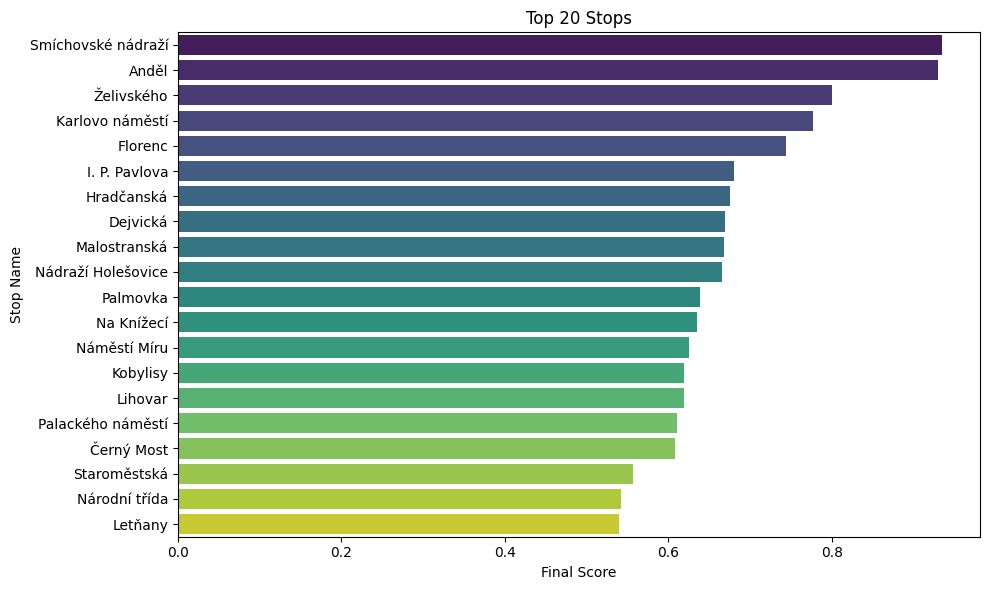

In [268]:
top_stops = best_stop.head(20)

plot_top_stops(
    df=top_stops,
    x_col='final_score',
    y_col='stop_name',
    top_n=20,
    title="Top 20 Stops",
    figsize=(10, 6),
    palette='viridis'
)

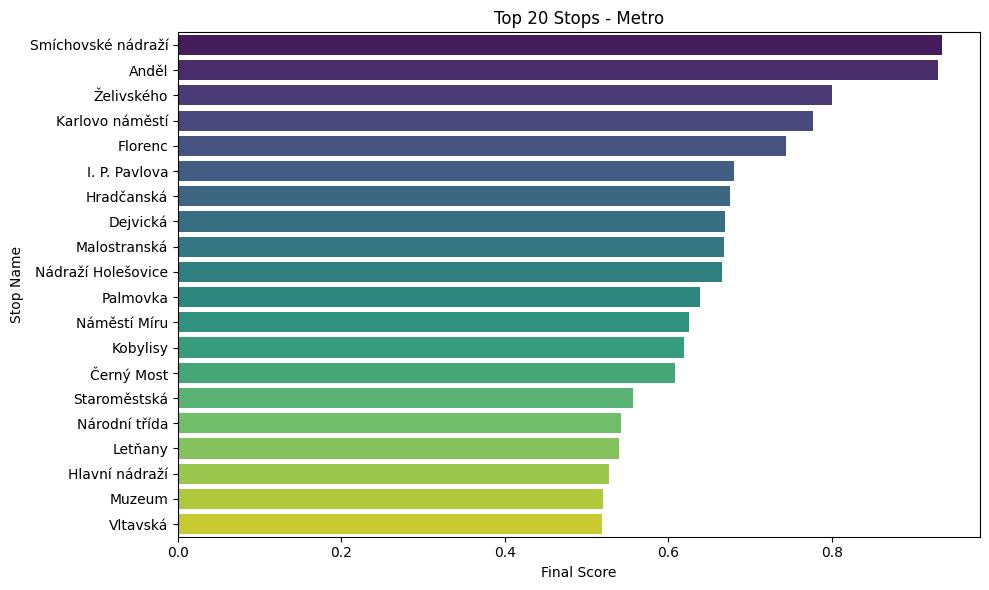

In [269]:
top_metro = best_stop[best_stop['stop_name'].isin(metro_stops)].head(20)

plot_top_stops(
    df=top_metro,
    x_col='final_score',
    y_col='stop_name',
    top_n=20,
    title="Top 20 Stops - Metro",
    figsize=(10, 6),
    palette='viridis'
)

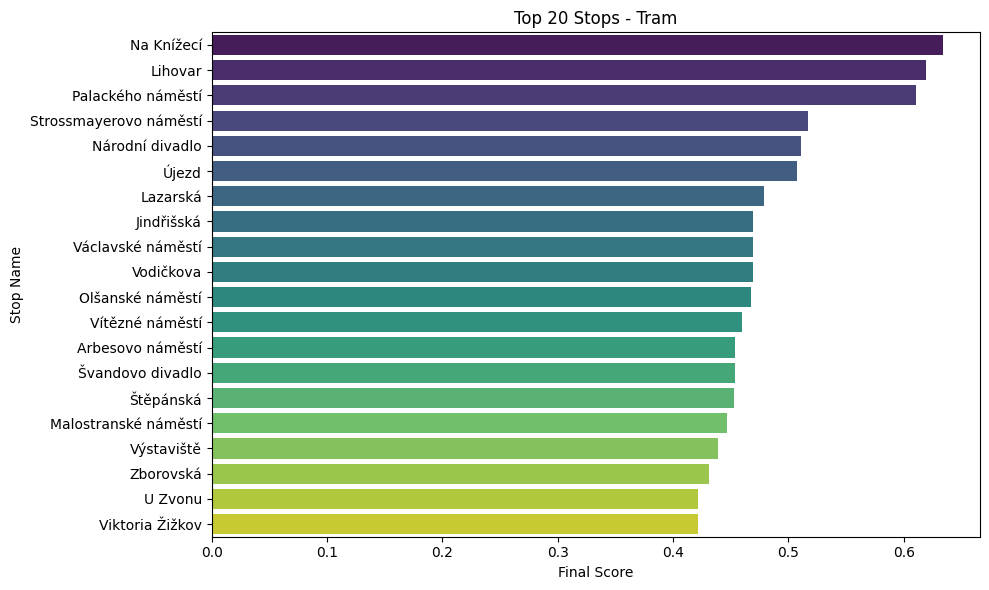

In [270]:
top_tram = best_stop[best_stop['stop_name'].isin(tram_stops)].head(20)

plot_top_stops(
    df=top_tram,
    x_col='final_score',
    y_col='stop_name',
    top_n=20,
    title="Top 20 Stops - Tram",
    figsize=(10, 6),
    palette='viridis'
)

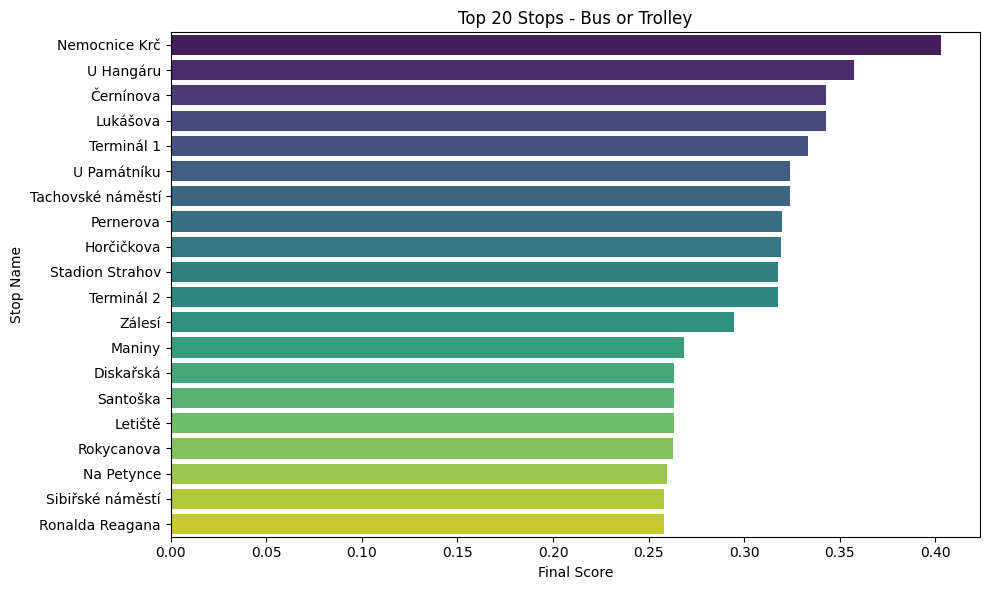

In [271]:
top_bus = best_stop[best_stop['stop_name'].isin(bus_stops + trolley_stops)].head(20)

plot_top_stops(
    df=top_bus,
    x_col='final_score',
    y_col='stop_name',
    top_n=20,
    title="Top 20 Stops - Bus or Trolley",
    figsize=(10, 6),
    palette='viridis'
)

### old code

In [45]:
## create a new dataset which includes both high visibility and stops in good loc ##

# creating a new dataset
best_stop = high_visibility_merged[["stop_name"]]

# normalising high visibility
best_stop["trip_count"] = (high_visibility_merged['trip_id'] - high_visibility_merged['trip_id'].min()) / (
    high_visibility_merged['trip_id'].max() - high_visibility_merged['trip_id'].min())

# normalising high visibility
best_stop["repetition"] = (repetition_stops['trip_id'] - repetition_stops['trip_id'].min()) / (
    repetition_stops['trip_id'].max() - repetition_stops['trip_id'].min())

# stops in highly visited locations
best_stop["good_loc"] = best_stop['stop_name'].isin(visited_stops).astype(int)


best_stop.head()

,stop_name,trip_count,repetition,good_loc
0,Želivského,1.000000,1.000000,0
1,Smíchovské nádraží,0.918072,0.999197,1
2,Anděl,0.912144,0.853453,1
3,Palmovka,0.798077,0.810593,0
4,Kobylisy,0.774499,0.808967,0


In [113]:
## defining weights ##
w_visibility = 0.8
w_location = 0.2

In [114]:
## computing final score for each stop ##
best_stop['final_score'] = (
    w_visibility * best_stop["trip_count"] +
    w_location * best_stop["good_loc"]
)

best_stop = best_stop.sort_values("final_score", ascending=False).reset_index(drop = True)

In [139]:
best_stop.head(10)

,stop_name,trip_count,good_loc,final_score
0,Smíchovské nádraží,0.918905,1,0.935124
1,Anděl,0.913507,1,0.930806
2,Želivského,1.000000,0,0.800000
3,Karlovo náměstí,0.722880,1,0.778304
4,Florenc,0.683123,1,0.746498
5,I. P. Pavlova,0.599658,1,0.679726
6,Hradčanská,0.593865,1,0.675092
7,Dejvická,0.586625,1,0.669300
8,Malostranská,0.584255,1,0.667404
9,Nádraží Holešovice,0.580437,1,0.664350


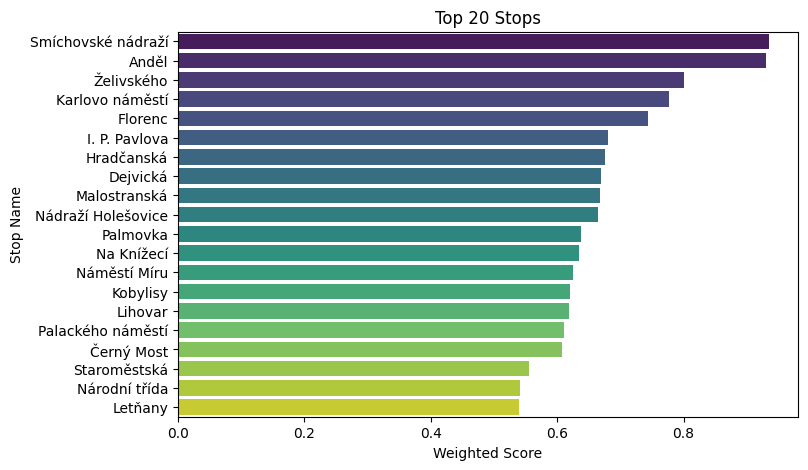

In [37]:
## plotting the top X stops ##
top_stops = best_stop.head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='stop_name',
    data=top_stops,
    hue='stop_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Stop Name')
plt.title('Top 20 Stops')
plt.show()

### best stops by type of route (případně dodělat)

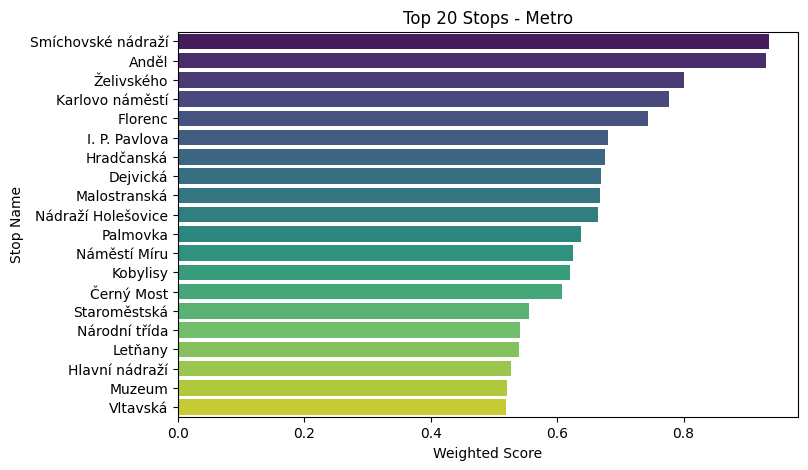

In [120]:
top_metro = best_stop[best_stop['stop_name'].isin(metro_stops)].head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='stop_name',
    data=top_metro,
    hue='stop_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Stop Name')
plt.title('Top 20 Stops - Metro')
plt.show()

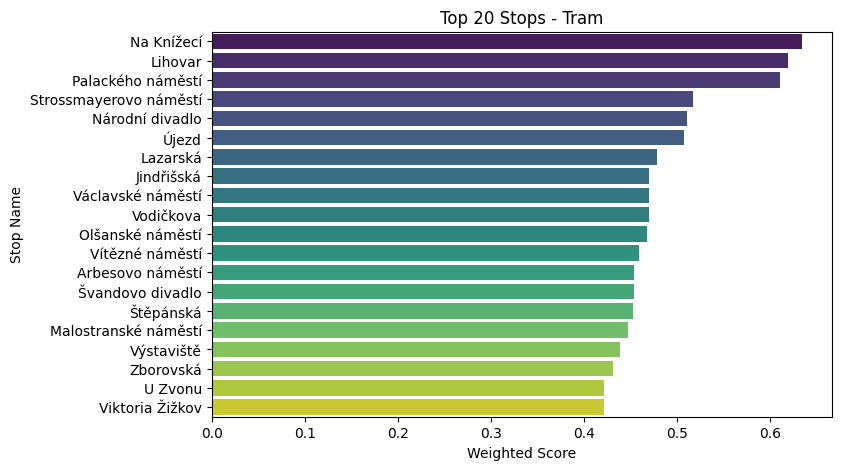

In [121]:
top_tram = best_stop[best_stop['stop_name'].isin(tram_stops)].head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='stop_name',
    data=top_tram,
    hue='stop_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Stop Name')
plt.title('Top 20 Stops - Tram')
plt.show()

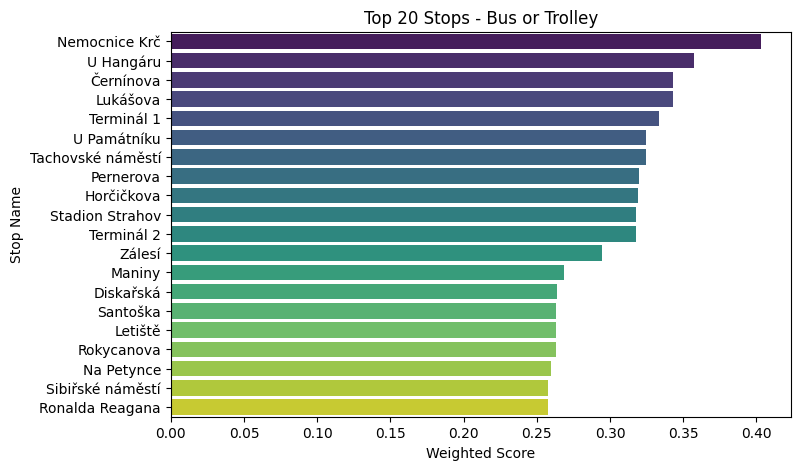

In [123]:
top_bus = best_stop[best_stop['stop_name'].isin(bus_stops + trolley_stops)].head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='stop_name',
    data=top_bus,
    hue='stop_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Stop Name')
plt.title('Top 20 Stops - Bus or Trolley')
plt.show()

## BEST ROUTE

uses longest exposure + connects highly visited location - high repetition

formula:

$$ final.score = w_{duration} \cdot duration + w_{numstops} \cdot num.stops + w_{connection} \cdot connection - w_{repetition} \cdot repetition $$

plan:

1. normalise longest exposure, high repetition
2. create a dummy variable if connects stops in highly visited area
3. define weights
4. for each route compute its score
5. plot the resutls

In [272]:
class RouteScorer:
    """
    Class to compute normalized scores for routes based on duration, number of stops,
    good location connections, and repetition.
    """

    def __init__(
        self,
        avg_duration_per_route,
        avg_stops_per_route,
        connected_routes,
        high_repetition,
        routes_df
    ):
        self.avg_duration_per_route = avg_duration_per_route
        self.avg_stops_per_route = avg_stops_per_route
        self.connected_routes = set(connected_routes)
        self.high_repetition = high_repetition
        self.routes_df = routes_df

        # Initialize the best_route DataFrame
        self.best_route = None

    def normalize_column(self, series):
        """Normalize a pandas Series to 0-1 scale."""
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series * 0  # avoid division by zero
        return (series - min_val) / (max_val - min_val)

    def compute_scores(self):
        """Compute normalized metrics and merge into best_route DataFrame."""

        # Start with route_id and route_short_name
        self.best_route = self.avg_duration_per_route[["route_id", "route_short_name"]].copy()

        # Normalize avg duration
        self.best_route["duration"] = self.normalize_column(self.avg_duration_per_route['duration_minutes'])

        # Normalize number of stops
        self.best_route["num_stops"] = self.normalize_column(self.avg_stops_per_route['num_stops'])

        # Good location dummy
        self.best_route["good_loc"] = self.best_route['route_id'].isin(self.connected_routes).astype(int)

        # Normalize high repetition
        self.best_route["repetition"] = self.normalize_column(self.high_repetition['trip_id'])

        # Merge route_type
        self.best_route = self.best_route.merge(
            self.routes_df[["route_id", "route_type"]],
            on="route_id",
            how="left"
        )

        return self.best_route

In [273]:
scorer = RouteScorer(
    avg_duration_per_route=avg_duration_per_route,
    avg_stops_per_route=avg_stops_per_route,
    connected_routes=connected_routes,
    high_repetition=high_repetition,
    routes_df=routes_df
)

best_route_df = scorer.compute_scores()
best_route_df.head(10)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,route_type
0,L911,911,1.000000,1.000000,1,1.000000,3
1,L910,910,0.946667,0.965517,1,0.741467,3
2,L95,95,0.933333,0.896552,1,0.702977,0
3,L136,136,0.906667,0.862069,1,0.692084,3
4,L908,908,0.893333,0.844828,1,0.559187,3
5,L913,913,0.893333,0.827586,1,0.519971,3
6,L904,904,0.880000,0.810345,1,0.513435,3
7,L166,166,0.853333,0.775862,0,0.506899,3
8,L907,907,0.840000,0.758621,1,0.462600,3
9,L97,97,0.826667,0.758621,1,0.427015,0


In [274]:
def compute_final_route_score(
    best_route_df,
    w_duration=0.4,
    w_numstops=0.35,
    w_connection=0.1,
    w_repetition=0.15
):
    """
    Compute the final weighted score for each route.

    Parameters:
        best_route_df (pd.DataFrame): Must contain columns:
                                      'duration', 'num_stops', 'good_loc', 'repetition'
        w_duration (float): Weight for normalized duration
        w_numstops (float): Weight for normalized number of stops
        w_connection (float): Weight for good location connection dummy
        w_repetition (float): Weight for repetition penalty (subtracted)
    
    Returns:
        pd.DataFrame: DataFrame with added 'final_score', sorted descending
    """

    df = best_route_df.copy()

    # Compute weighted final score
    df['final_score'] = (
        w_duration * df['duration'] +
        w_numstops * df['num_stops'] +
        w_connection * df['good_loc'] -
        w_repetition * df['repetition']
    )

    # Sort descending
    df = df.sort_values('final_score', ascending=False).reset_index(drop=True)

    return df

In [275]:
best_route_scored = compute_final_route_score(
    best_route_df,
    w_duration=0.4,
    w_numstops=0.35,
    w_connection=0.1,
    w_repetition=0.15
)

best_route_scored.head(10)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,route_type,final_score
0,L910,910,0.946667,0.965517,1,0.741467,3,0.705378
1,L911,911,1.000000,1.000000,1,1.000000,3,0.700000
2,L95,95,0.933333,0.896552,1,0.702977,0,0.681680
3,L908,908,0.893333,0.844828,1,0.559187,3,0.669145
4,L913,913,0.893333,0.827586,1,0.519971,3,0.668993
5,L136,136,0.906667,0.862069,1,0.692084,3,0.660578
6,L904,904,0.880000,0.810345,1,0.513435,3,0.658605
7,L97,97,0.826667,0.758621,1,0.427015,0,0.632132
8,L907,907,0.840000,0.758621,1,0.462600,3,0.632127
9,L98,98,0.786667,0.741379,1,0.405955,0,0.613256


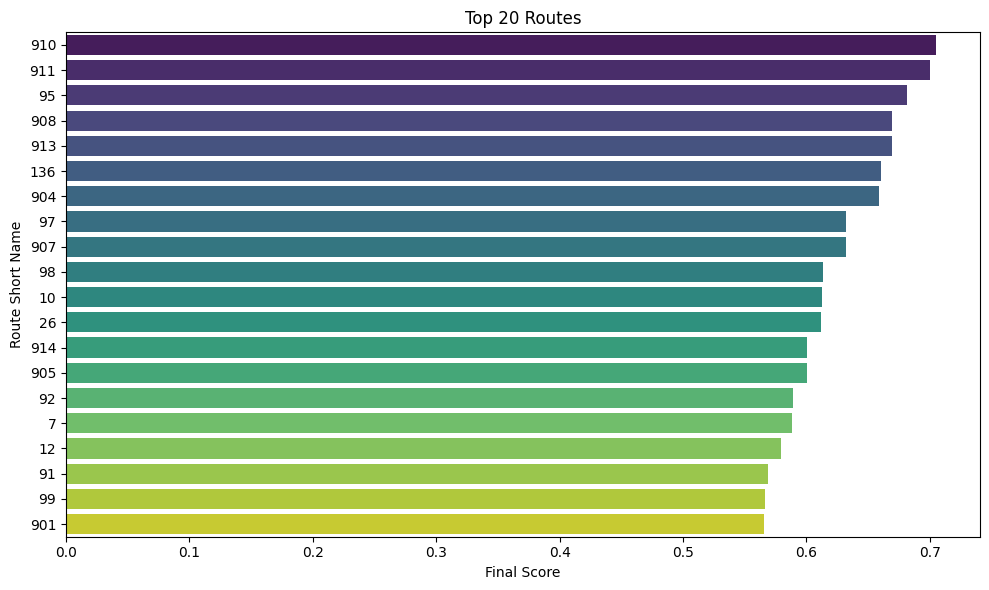

In [276]:
top_routes = best_route.head(20)

plot_top_stops(
    df=top_routes,
    x_col='final_score',
    y_col='route_short_name',
    top_n=20,
    title="Top 20 Routes",
    figsize=(10, 6),
    palette='viridis'
)

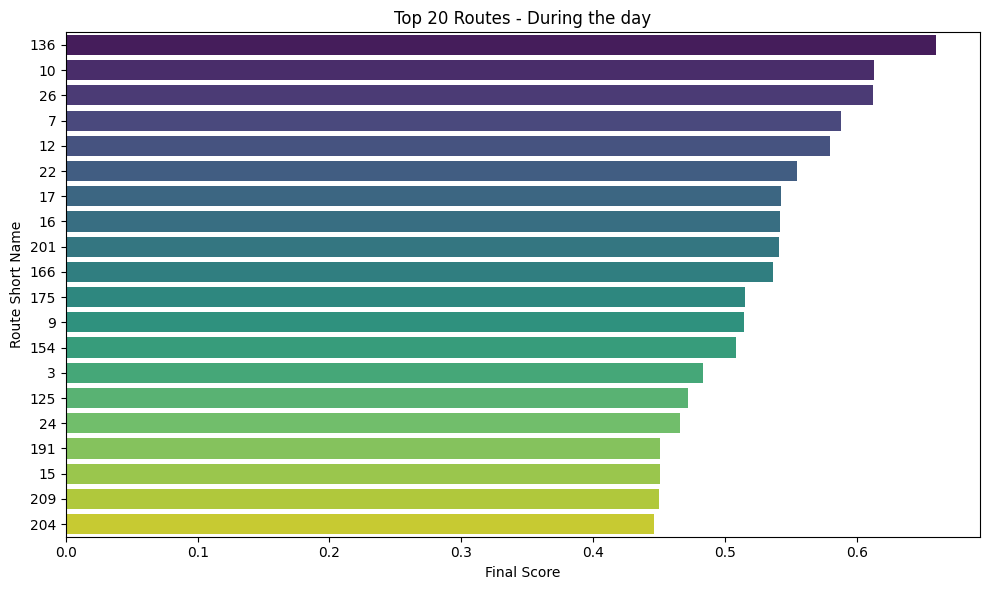

In [281]:
is_day = routes_df.loc[routes_df['is_night'] == 0, 'route_short_name'].tolist()
top_day = best_route[best_route['route_short_name'].isin(is_day)].head(20)

plot_top_stops(
    df=top_day,
    x_col='final_score',
    y_col='route_short_name',
    top_n=20,
    title="Top 20 Routes - During the day",
    figsize=(10, 6),
    palette='viridis'
)

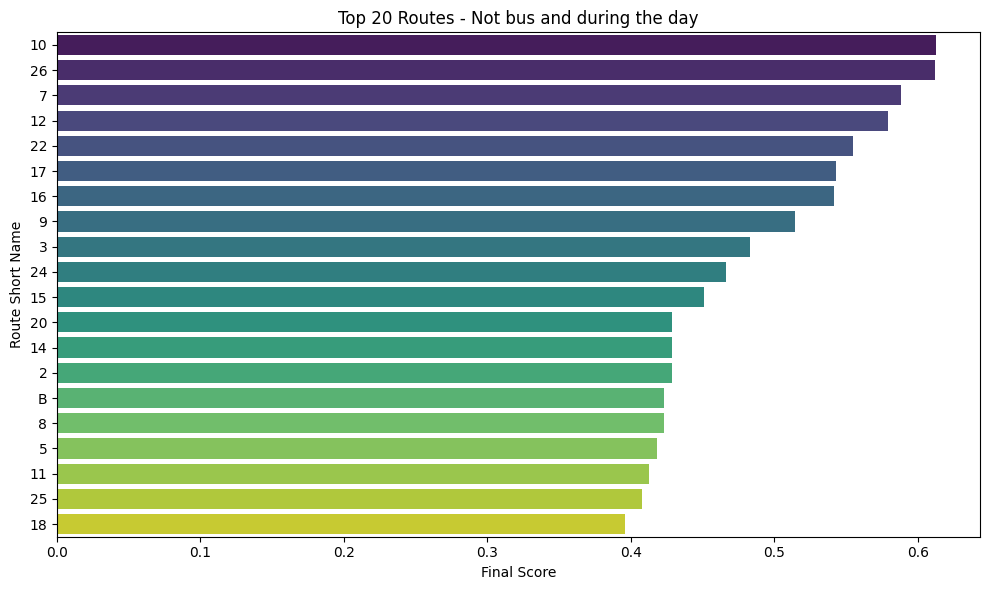

In [280]:
top_not_bus = best_route[best_route['route_type'] != 3]
top_not_bus = top_not_bus[top_not_bus['route_short_name'].isin(is_day)].head(20)

plot_top_stops(
    df=top_not_bus,
    x_col='final_score',
    y_col='route_short_name',
    top_n=20,
    title="Top 20 Routes - Not bus and during the day",
    figsize=(10, 6),
    palette='viridis'
)

### old code

In [170]:
## defining new dataset ##

# creating a new dataset
best_route = avg_duration_per_route[["route_id", "route_short_name"]].copy()

# normalising avg duration per route
best_route["duration"] = (avg_duration_per_route['duration_minutes'] - avg_duration_per_route['duration_minutes'].min()) / (
    avg_duration_per_route['duration_minutes'].max() - avg_duration_per_route['duration_minutes'].min())

# normalising number of stops
best_route["num_stops"] = (avg_stops_per_route['num_stops'] - avg_stops_per_route['num_stops'].min()) / (
    avg_stops_per_route['num_stops'].max() - avg_stops_per_route['num_stops'].min())

# connects stops in highly visited locations
best_route["good_loc"] = best_route['route_id'].isin(connected_routes).astype(int)

# normalising high repetition
best_route["repetition"] = (high_repetition['trip_id'] - high_repetition['trip_id'].min()) / (
    high_repetition['trip_id'].max() - high_repetition['trip_id'].min())

# merging on route_type
best_route = best_route.merge(routes_df[["route_id", "route_type"]], on = "route_id")

best_route.head(5)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,route_type
0,L911,911,1.000000,1.000000,1,1.000000,3
1,L910,910,0.946667,0.965517,1,0.741467,3
2,L95,95,0.933333,0.896552,1,0.702977,0
3,L136,136,0.906667,0.862069,1,0.692084,3
4,L908,908,0.893333,0.844828,1,0.559187,3


In [171]:
## defining weights ##
w_duration = 0.4
w_numstops = 0.35
w_connection = 0.1
w_repetiton = 0.15

In [172]:
## computing final score for each route ##
best_route['final_score'] = (
    w_duration * best_route['duration'] +
    w_numstops * best_route['num_stops'] +
    w_connection * best_route['good_loc'] -
    w_repetiton * best_route['repetition']  # subtract penalty
)

best_route = best_route.sort_values("final_score", ascending=False).reset_index(drop = True)

In [173]:
best_route.head(10)

,route_id,route_short_name,duration,num_stops,good_loc,repetition,route_type,final_score
0,L910,910,0.946667,0.965517,1,0.741467,3,0.705378
1,L911,911,1.000000,1.000000,1,1.000000,3,0.700000
2,L95,95,0.933333,0.896552,1,0.702977,0,0.681680
3,L908,908,0.893333,0.844828,1,0.559187,3,0.669145
4,L913,913,0.893333,0.827586,1,0.519971,3,0.668993
5,L136,136,0.906667,0.862069,1,0.692084,3,0.660578
6,L904,904,0.880000,0.810345,1,0.513435,3,0.658605
7,L97,97,0.826667,0.758621,1,0.427015,0,0.632132
8,L907,907,0.840000,0.758621,1,0.462600,3,0.632127
9,L98,98,0.786667,0.741379,1,0.405955,0,0.613256


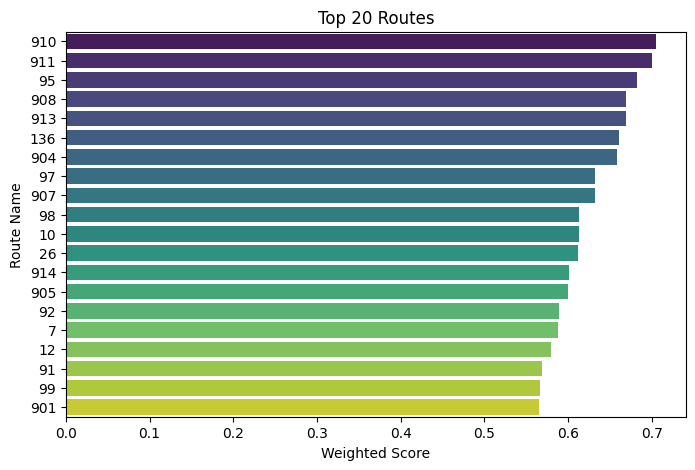

In [168]:
## plotting the top X stops ##
top_routes = best_route.head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='route_short_name',
    data=top_routes,
    hue='route_short_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Route Name')
plt.title('Top 20 Routes')
plt.show()

### best routes by type (případně dodělat)

In [162]:
is_day = routes_df.loc[routes_df['is_night'] == 0, 'route_short_name'].tolist()

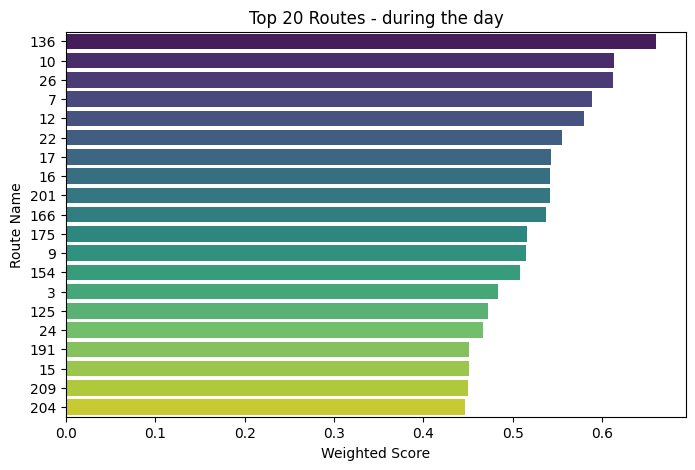

In [169]:
top_day = best_route[best_route['route_short_name'].isin(is_day)].head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='route_short_name',
    data=top_day,
    hue='route_short_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Route Name')
plt.title('Top 20 Routes - during the day')
plt.show()

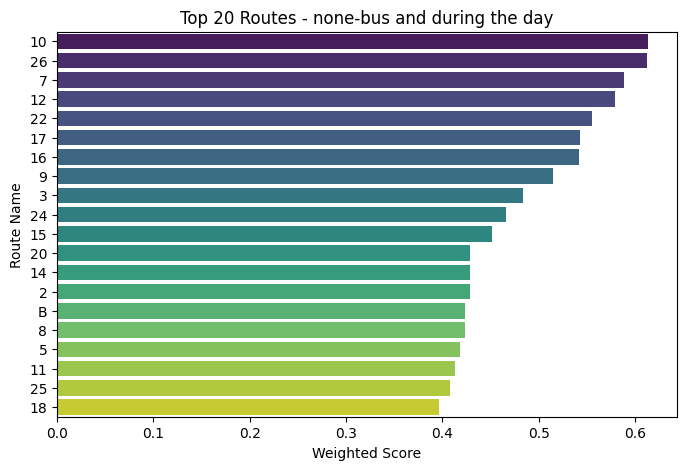

In [178]:
top_not_bus = best_route[best_route['route_type'] != 3]
top_not_bus = top_not_bus[top_not_bus['route_short_name'].isin(is_day)].head(20)

plt.figure(figsize=(8,5))
sns.barplot(
    x='final_score',
    y='route_short_name',
    data=top_not_bus,
    hue='route_short_name',  # use y variable as hue
    dodge=False,
    palette='viridis',
    legend=False  # hides extra legend
)
plt.xlabel('Weighted Score')
plt.ylabel('Route Name')
plt.title('Top 20 Routes - none-bus and during the day')
plt.show()

## NOTES

__TO DO (old)__

1. __high visibility:__
- sort by route type -> when one stop has metro, tram, and bus, do we just say that it's metro
- in other words, do we sort by metro > tram > trolley > bus (?)

2. __longest exposure__
- do we sort by route type, since now trains have the longest duration
- or just make exclude regional routes outside of Prague city (or if the route is at night)
- for the most amount of stops, do we once again sort by route type, or not

3. __highest repetition__
- do we sort for weekdays, weekends, full weeks
- and do we sort by route type

```text
my opinions:
1. i think the proposed [metro > tram > trolley > bus] system makes sense, but i would have to look into it a bit more, probably on saturday
2. i think we should exclude regional routes. i will look into doing that during processing, so we do not need to worry about it in the notebook file, i will report back tomorrow
3. i think we should sort by all weekdays combined as one output, by weekends as a second output and full weeks as a third output. 

- concerning sorting by route type, i think its an important distinction and it would probably be useful to provide separate outputs for each, both in longest exposure and highest repetition
```

__BEST ROUTES__
- exclude regional trains
- maybe do it by weekdays or weekends